# EcoTech Connect Workshop on RL!
### The good, the bad and the ugly?

## 1. Setting: What is RL?

Machine learning for sequential decisions made on observations! (Think like a computer playing a board game: the computer observes e.g. your card deck, the cards that are on the table, etc., then makes an action which alters the state of the game, and then a new 'turn' starts.)

RL has two components:
- the 'environment' which is the 'system' with which the computer interacts. E.g. it is the thing that keeps track of what is the current 'state' of the game (which cards are on which deck, which cards are on the table, in which order, etc.)
- The learning algorithm: how the computer gathers experience (interactions with the game), how the computer updates its strategy

## 2. How do people do RL?

Many options, but the one I've been using a lot is:
- Gymnasium framework for environments
- Stable baselines framework for learning algorithms

## 3. Gymnasium environments

Here I coded an environment which simulates a fish population $N_t$ according to the following equation:

$$
N_{t+1} = N_t + r N_t \times (1 - N_t/K) - \frac{\beta H N_t}{c^2 + N_t^2} + \text{noise}
$$

ie: population change = logistic growth $-$ predation by constant predator population $+$ noise.

In [1]:
import fishing_env as fe

In [2]:
fishing_env = fe.FishingEnv()

OK let's take a look at what happens in the code this environment...

... (elevator music) ...

### 3.1 Let's use the env to simulate time dynamics!

In [3]:
fishing_env.reset()
fishing_env.step(action=[-1])

(array([-0.5000541], dtype=float32), 0.0, False, False, {})

In [4]:
import dynamics as dyn

simulation = dyn.simulate_dynamics(
    T = fishing_env.max_t,
    params = fishing_env.parameters,
    init_pop = 0.5
)

import pandas as pd

sim_df = pd.DataFrame(simulation)

<Axes: xlabel='t'>

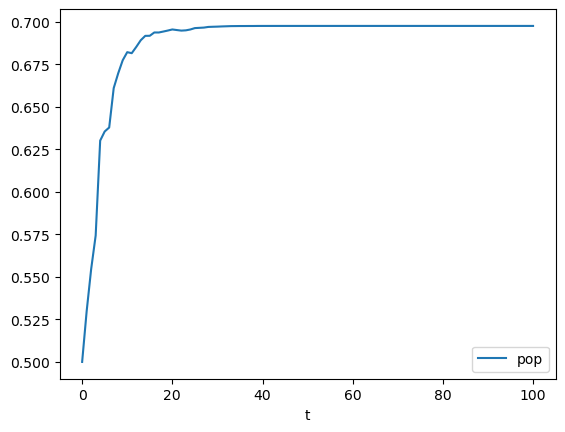

In [5]:
sim_df.plot(x='t')

## 4. Learning with stable baselines

The baselines were not as stable at the start so now the actual package is `stable_baselines3`. Such is life in the tropics.

There's many (MANY) learning algorithms out there. Most of them will be good at some stuff and bad at a lot of stuff. There's one, PPO, which is pretty decent across the board so it's a good algo to try out in a research project! (Especially in the early stages!)

In [6]:
from stable_baselines3 import PPO

### 4.1 Lil trick to speed up the algorithm

Algorithm gathers a bunch of 'step' data (ie. using the environment `step` function with actions chosen according to its current best policy), and *then* updates the policy to a better one (hopefully). This is one training step which could use 1000s or 10,000s of steps. We can paralellize the process of gathering these steps for more efficiency! And it's easy!

In [7]:
from gymnasium.envs.registration import register
from stable_baselines3.common.env_util import make_vec_env

register(id="FishingEnv", entry_point="fishing_env:FishingEnv")

quadruple_threat = make_vec_env("FishingEnv", n_envs=4)

/opt/conda/lib/python3.12/site-packages/gymnasium/envs/registration.py:734: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that is not in the possible render_modes ([]).
  logger.warn(


RL libraries love to give you warnings. Most of the time they're kinda irrelevant so don't let the red highlight alter your inner peace!

In [8]:
agent = PPO("MlpPolicy", env=quadruple_threat, verbose=0, tensorboard_log="../../logs")

In [9]:
agent.learn(total_timesteps = 1_000_000, progress_bar=True)

Output()

# 5. OK let's see what comes out...

In [10]:
# plot the policy
import numpy as np
import pandas as pd

policy_data = {
    'population': [],
    'harvest_intensity': [],
}

fishing_env.reset()
for pop in np.linspace(0, 0.8):
    fishing_env.pop = np.array([pop], dtype=np.float32)
    obs = fishing_env.observe()
    action = agent.predict(obs)
    harvest_intensity = fishing_env.compute_harvest(action)[0]
    policy_data['population'].append(pop)
    policy_data['harvest_intensity'].append(harvest_intensity)

policy_df = pd.DataFrame(policy_data)

<Axes: xlabel='population'>

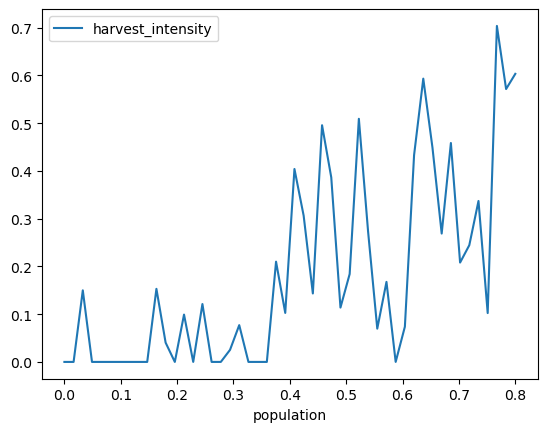

In [11]:
policy_df.plot(x='population')

In [12]:
from stable_baselines3.common.evaluation import evaluate_policy

/opt/conda/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


array([[<Axes: title={'center': 'reward'}>]], dtype=object)

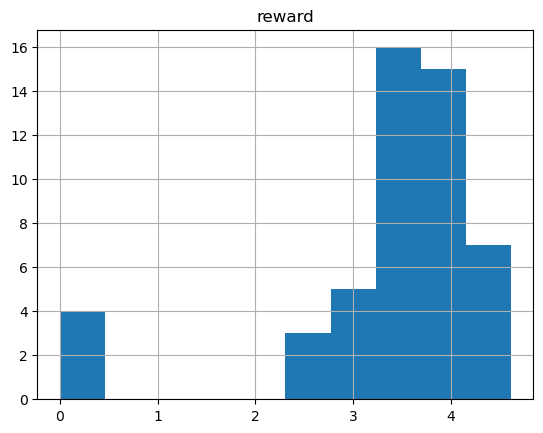

In [13]:
n_eps = 50
rewards, ep_lengths = evaluate_policy(model = agent, env = fishing_env, n_eval_episodes=n_eps, return_episode_rewards=True)

pd.DataFrame({
    'reward': rewards,
}).hist()

In [31]:
# timeseries
sim = {
    't': [],
    'population': [],
    'harvest_intensity': [],
}

obs, info = fishing_env.reset()
for t in range(100):
    action, info = agent.predict(obs)
    sim['t'].append(t)
    sim['population'].append(fishing_env.pop[0])
    sim['harvest_intensity'].append(fishing_env.compute_harvest(action))
    obs, reward, terminated, truncated, info = fishing_env.step(action)

sim_df = pd.DataFrame(sim)

<Axes: xlabel='t'>

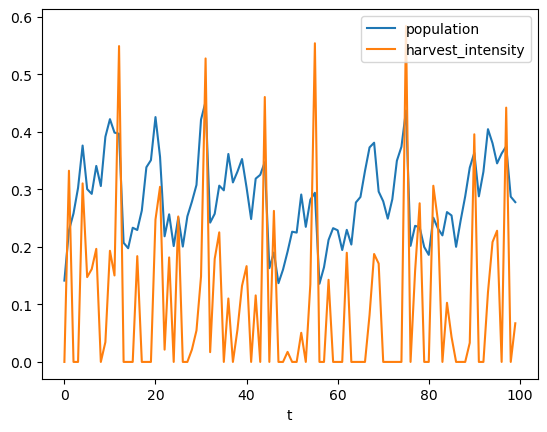

In [32]:
sim_df.plot(x='t')

## Well what if...?


### ... we train for shorter time?

Very spiky, very crazy, not very efficient policy:

In [40]:
short_agent = PPO("MlpPolicy", env=quadruple_threat, verbose=0, tensorboard_log="../../logs")
short_agent.learn(total_timesteps = 10_000, progress_bar=True)

Output()

In [41]:
short_agent_policy_data = {
    'population': [],
    'harvest_intensity': [],
}

fishing_env.reset()
for pop in np.linspace(0, 0.8):
    fishing_env.pop = np.array([pop], dtype=np.float32)
    obs = fishing_env.observe()
    action = agent.predict(obs)
    harvest_intensity = fishing_env.compute_harvest(action)[0]
    short_agent_policy_data['population'].append(pop)
    short_agent_policy_data['harvest_intensity'].append(harvest_intensity)

short_agent_policy_df = pd.DataFrame(short_agent_policy_data)

<Axes: xlabel='population'>

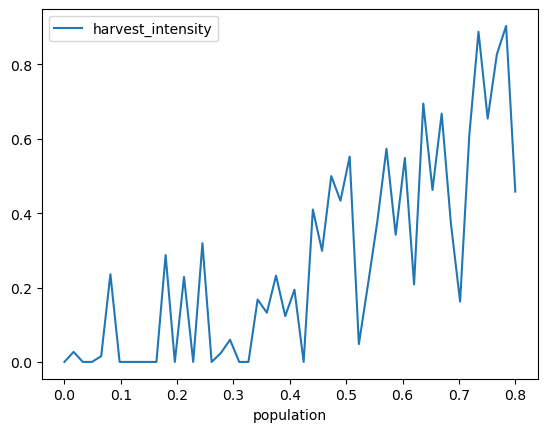

In [42]:
short_agent_policy_df.plot(x='population')

Honestly more sensible than I expected!